# 学習開始
---
### 利用バージョン
python 2 (python 3にしたかったけど、色々環境設定しないといけなさそうなので・・)

## 概要
ここでは、
* GPUの使用有無、バッチサイズ、繰り返し回数を指定します。
* 実際にAIに学習させます。
* 学習ログ確認
* 繰り返し学習をするための.pyファイル作成

といった事をします。

## 変数定義
* GPUを使う場合は0を、使わない場合は-1をgpu_id設定します。
* パラメータ更新する頻度(多分・・・）をbatchsizeに指定します。
* 何回繰り返して終了するかをmax_epochに指定します。

In [1]:
gpu_id = 0
batchsize = 500
max_epoch = 20

## 学習スタート
私も中途半端な理解ではありますが、ここからはちょっと細かく説明します。

In [7]:
from PIL import Image
from glob import glob
import os
import numpy as np
import pandas as pd
import chainer
from chainer import datasets
from chainer import iterators
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
from chainer import training
from chainer.training import extensions
from chainer import serializers


#特定フォルダ配下にあるファイルを全削除する関数
def remove_dir_and_file(top):
    for root, dirs, files in os.walk(top, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))

def transform(data):
    img, lable = data
    img = img / 255.
    return img, lable

# AIのモデル定義
class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=2):
        # パラメータを持つ層の登録
        super(MLP, self).__init__(
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(None, n_mid_units),
            l3=L.Linear(None, n_out),
        )

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


def main():
    
    # 出力フォルダ配下のファイル全削除
    remove_dir_and_file(u'result')

    # 画像ファイル名と教師データの一覧ファイルのパス格納
    image_files = os.path.join(u'dataset', '03_duplicate_pict_anser.csv')

    # datasets.LabeledImageDatasetでいい感じにデータセットとして読み込んでくれます。
    dataset = datasets.LabeledImageDataset(image_files)
    #print (u'dataset')
    #print dataset[0]
    #print (u'---')
    
    # データ部を0〜1の値にする必要があるため255で割ります
    dataset = chainer.datasets.TransformDataset(dataset, transform)
    
    # 8割を学習データに、2割をテストデータにします。
    split_at = int(len(dataset) * 0.8)
    train, test = datasets.split_dataset(dataset, split_at)

    # バッチ実行か、シャッフルしてデータ使うかなどの指定
    train_iter = iterators.SerialIterator(train, batchsize, shuffle=True)
    test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=True)

    # モデルの定義。GPU使うかもここで指定。
    # model = MLP()
    # model.to_gpu(gpu_id)

    # モデルをClassifierで包んで、ロスの計算などをモデルに含める
    model = MLP()
    model = L.Classifier(model)
    model.to_gpu(gpu_id)

    # 最適化手法の選択
    optimizer = optimizers.SGD()
    optimizer.setup(model)

    # UpdaterにIteratorとOptimizerを渡す
    updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

    # TrainerにUpdaterを渡す
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')

    # ログの出力方法などの定義
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
    trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    trainer.extend(extensions.dump_graph('main/loss'))

    # トレーニングスタート！！
    trainer.run()
    
    # 学習結果の保存
    model.to_cpu() # CPUで計算できるようにしておく
    serializers.save_npz(os.path.join(u'result', u'sakamotsu.model'), model)
    
if __name__ == '__main__':
    main()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           2.01783     0.5395         1.16159               0                         3.05489       
2           1.57371     0.5            0.702801              0                         11.7868       
3           0.690211    0.625          0.708669              0                         20.5183       
4           0.688681    0.6265         0.71525               0                         29.2846       
5           0.688086    0.613          0.719449              0                         38.0382       
6           0.685114    0.6435         0.727616              0                         46.8265       
7           0.686194    0.608          0.729369              0                         54.9505       
8           0.683345    0.6325         0.746942              0                         63.7015       
9           0.681946    0.6245         0.785712              0                      

## 学習ログの表示

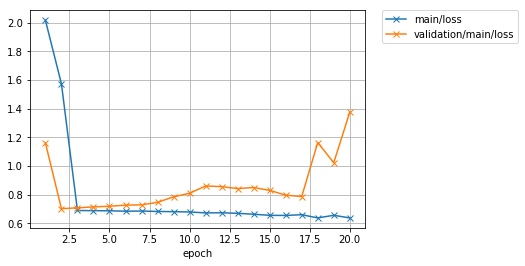

In [9]:
from IPython.display import Image
Image(filename=os.path.join(u'result', u'loss.png'))

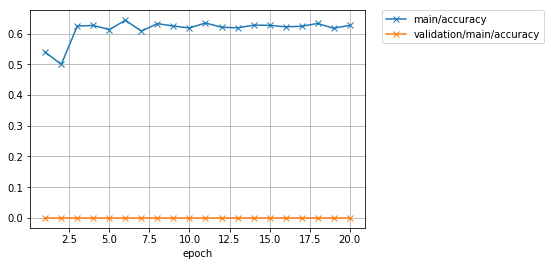

In [10]:
Image(filename=os.path.join(u'result', u'accuracy.png'))

In [8]:
# ちゃんと保存されていることを確認
%ls -la result/sakamotsu.model

-rw-r--r-- 1 moriyama moriyama 69656430  3月  5 10:12 result/sakamotsu.model


## pyファイルの作成

In [ ]:
import subprocess
subprocess.call(['jupyter', 'nbconvert', '--to', 'python', '04_startTrainingSakamotsu.ipynb'])
%ls -la 04_startTrainingSakamotsu.py